In [2]:
!pip install --upgrade pip
!pip install python-decouple
!pip install geoalchemy2
!pip install shapely
!pip install scipy
!pip install hyperas

Requirement already up-to-date: pip in /anaconda3/lib/python3.7/site-packages (19.1.1)


In [3]:
from sqlalchemy import create_engine, func, text
from sqlalchemy.orm import sessionmaker
from decouple import config
from shapely import wkb, wkt
from shapely.geometry import Point
from geoalchemy2.shape import to_shape 

import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
import re
from matplotlib import pyplot as plt
import random

from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV

from hyperas.distributions import uniform

Using TensorFlow backend.


In [4]:
"""Contains models for DB."""

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, BigInteger, Integer, String, DateTime, \
    ForeignKey, Float, LargeBinary
from sqlalchemy.orm import relationship
from geoalchemy2 import Geometry


BASE = declarative_base()


class City(BASE):
    """City model for DB. Has information of cities."""
    __tablename__ = 'city'
    id            = Column(BigInteger, primary_key=True)
    city          = Column(String, unique=False, nullable=False)
    state         = Column(String, unique=False, nullable=True)
    country       = Column(String, unique=False, nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    blocks        = relationship("Blocks", back_populates="city")
    zipcodes      = relationship("ZipcodeGeom", back_populates="city")
    incidents     = relationship("Incident", back_populates="city")


class Blocks(BASE):
    """Block model for DB. Has information of city blocks for a related city
        id."""
    __tablename__ = 'block'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    population    = Column(Integer, nullable=False)
    prediction    = Column(LargeBinary, nullable=True)
    year          = Column(Integer, nullable=True)
    month         = Column(Integer, nullable=True)
    city          = relationship("City", back_populates="blocks")
    incidents     = relationship("Incident", back_populates="block")

class ZipcodeGeom(BASE):
    """Zipcode geometry model for DB. Has information of zipcodes and related
        city id."""
    __tablename__ = 'zipcodegeom'
    id            = Column(BigInteger, primary_key=True)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    zipcode       = Column(String, nullable=False, unique=True)
    shape         = Column(Geometry(geometry_type='MULTIPOLYGON'), nullable=False)
    city          = relationship("City", back_populates="zipcodes")

class Incident(BASE):
    """Incident model for DB. Has information of a specific crime, including
        where it took place, when it took place, and the type of crime that
        occurred."""
    __tablename__ = 'incident'
    id            = Column(BigInteger, primary_key=True)
    crimetypeid   = Column(BigInteger, ForeignKey('crimetype.id'), nullable=False)
    locdescid     = Column(BigInteger, ForeignKey('locdesctype.id'), nullable=False)
    cityid        = Column(BigInteger, ForeignKey('city.id'), nullable=False)
    blockid       = Column(BigInteger, ForeignKey('block.id'), nullable=False)
    location      = Column(Geometry(geometry_type='POINT'), nullable=False)
    datetime      = Column(DateTime, nullable=False)
    hour          = Column(Integer, nullable=False)
    dow           = Column(Integer, nullable=False)
    month         = Column(Integer, nullable=False)
    year          = Column(Integer, nullable=False)
    city          = relationship("City", back_populates="incidents")
    block         = relationship("Blocks", back_populates="incidents")
    crimetype     = relationship("CrimeType", back_populates="incidents")
    locationdesc  = relationship("LocationDescriptionType", back_populates="incidents")

class CrimeType(BASE):
    """CrimeType model for DB. Has information of the types of crime, including
        a general description and the numerical severity of the crime."""
    __tablename__ = 'crimetype'
    id            = Column(BigInteger, primary_key=True)
    category      = Column(String, unique=True, nullable=False)
    severity      = Column(Integer, nullable=False)
    incidents     = relationship("Incident", back_populates="crimetype")


class LocationDescriptionType(BASE):
    """Location description model for DB. Has information on the type of
        location that the crime took place."""
    __tablename__ = 'locdesctype'
    id            = Column(BigInteger, primary_key=True)
    key1          = Column(String, nullable=False)
    key2          = Column(String, nullable=False)
    key3          = Column(String, nullable=False)
    incidents     = relationship("Incident", back_populates="locationdesc")


class Job(BASE):
    """Job model for DB and redis. Has information on the status and result of
        redis queue job."""
    __tablename__ = 'job'
    id            = Column(BigInteger, primary_key=True)
    result        = Column(String, nullable=False)
    datetime      = Column(DateTime, nullable=False)

In [5]:
use_counts = True  # Use crime counts instead of severity ratings
do_gridsearch = False

if use_counts == True:
    SEVERITY_SCALING_FACTOR = 1000.
    SEVERITY_OPERATOR = '*'
else:
    SEVERITY_SCALING_FACTOR = 1000.
    SEVERITY_OPERATOR = '*'

def scale_data(X):
    if use_counts == True:
        X *= SEVERITY_SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        X *= SEVERITY_SCALING_FACTOR  # This gave us good results earlier with the 
                                      # severity/avg(population) SQL query
    return X

def descale_data(X):
    if use_counts == True:
        X /= SEVERITY_SCALING_FACTOR  # This we will use with the count(severity) SQL query
    else:
        X /= SEVERITY_SCALING_FACTOR  # This gave us good results earlier with the 
                                      # severity/avg(population) SQL query
    return X

class GetData(object):
    def go(self, SESSION, start_year, end_year):
        if use_counts == True:
            SQL_QUERY = \
                f'''
                    SELECT
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        incident.hour,
                        COUNT(*)/AVG(block.population) AS severity
                    FROM incident
                    INNER JOIN block ON incident.blockid = block.id
                    INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                        AND block.population > 0
                        AND incident.cityid = 1
                        AND incident.year >= {start_year}
                        AND incident.year <= {end_year}
                    GROUP BY
                        incident.blockid,
                        incident.datetime,
                        incident.year,
                        incident.month,
                        incident.dow,
                        incident.hour
                '''
        else:
            SQL_QUERY = \
                f'''
                    WITH
                        max_severity AS (
                            SELECT MAX(severity) AS severity
                            FROM (
                                SELECT SUM(crimetype.severity)/AVG(block.population) AS severity
                                FROM incident
                                INNER JOIN block ON incident.blockid = block.id INNER JOIN crimetype ON incident.crimetypeid = crimetype.id AND block.population > 0
                                GROUP BY
                                    incident.blockid,
                                    incident.year,
                                    incident.month,
                                    incident.dow
                            ) AS categories
                        ),
                        block_incidents AS (
                            SELECT
                                incident.blockid,
                                incident.datetime,
                                incident.year,
                                incident.month,
                                incident.dow,
                                SUM(crimetype.severity)/AVG(block.population) AS severity
                            FROM incident
                            INNER JOIN block ON incident.blockid = block.id
                            INNER JOIN crimetype ON incident.crimetypeid = crimetype.id
                                AND block.population > 0
                                AND incident.cityid = 1
                                AND incident.year >= {start_year}
                                AND incident.year <= {end_year}
                            GROUP BY
                                incident.blockid,
                                incident.datetime,
                                incident.year,
                                incident.month,
                                incident.dow
                        )
                    SELECT
                        block_incidents.blockid,
                        block_incidents.datetime,
                        block_incidents.year,
                        block_incidents.month,
                        block_incidents.dow,
                        block_incidents.severity/max_severity.severity AS severity
                    FROM block_incidents, max_severity        
                '''
        return SESSION.execute(text(SQL_QUERY)).fetchall()

In [6]:
DAY_OF_WEEK  = 0
DAY_OF_MONTH = 1
HOUR_OF_DAY  = 2

def fill_data(X, y, r, start_year, end_year, blockid_dict, data_type):
    
    def day_of_month(x):
        return x.day - 1

    def hour_of_day(x):
        return x.hour
    
    if r[2] == end_year:
        if data_type == DAY_OF_WEEK:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, r[4]] = float(r[5])
            #                                            ^^^^        ^^^^
            #                                            dow         risk
        elif data_type == DAY_OF_MONTH:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, day_of_month(r[1])] = float(r[5])
            #                                            ^^^^^^^^^^^^^^^^^^        ^^^^
            #                                                  dom                 risk
        elif data_type == HOUR_OF_DAY:
            #                     block id       0-based month
            #                vvvvvvvvvvvvvvvvv   vvvvvv
            y[blockid_dict[r[0]], r[3]-1, hour_of_day(r[1])] = float(r[5])
            #                                             ^^^^^^^^^^^^^^^         ^^^^
            #                                               hour of day           risk
        else:
            raise ValueError('Unsupported data type:', data_type)
    else:
        if data_type == DAY_OF_WEEK:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, r[4]] = float(r[5])
        elif data_type == DAY_OF_MONTH:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, day_of_month(r[1])] = float(r[5])
        elif data_type == HOUR_OF_DAY:
            X[blockid_dict[r[0]], 12*(r[2]-start_year-1)+r[3]-1, hour_of_day(r[1])] = float(r[5])
        else:
            raise ValueError('Unsupported data type:', data_type)

In [19]:
def process_data(data, start_year, end_year, blockid_dict, data_type):

    if data_type == DAY_OF_WEEK:
        X = np.zeros((len(blockid_dict), 24, 7))
        y = np.zeros((len(blockid_dict), 12, 7))
    elif data_type == DAY_OF_MONTH:
        X = np.zeros((len(blockid_dict), 24, 31))
        y = np.zeros((len(blockid_dict), 12, 31))
    elif data_type == HOUR_OF_DAY:
        X = np.zeros((len(blockid_dict), 24, 24))
        y = np.zeros((len(blockid_dict), 12, 24))
    
    # records is the list of rows we get from the query with this order:
    #   blockid, year, month, dow, hour, risk
    #   month is from 1 - 12

    for r in data:
        if r[0] in blockid_dict:
            fill_data(X, y, r, start_year, end_year, blockid_dict, data_type)

    X = scale_data(X)
    y = scale_data(y)

    #     for i in range(24):
    #         X[:, i, -1] = (start_year*12+i) / (2000 * 12)
        
    return X, y

In [8]:
from contextlib import contextmanager

@contextmanager
def session_scope():
    """Provide a transactional scope around a series of operations."""

    DB_URI  = config('DB_URI')
    ENGINE  = create_engine(DB_URI)
    Session = sessionmaker(bind=ENGINE)
    SESSION = Session()
    
    try:
        yield SESSION
        SESSION.commit()
    except:
        SESSION.rollback()
        raise
    finally:
        SESSION.close()


def ready_data(training_start_year, training_end_year, train_blockid_dict,
               testing_start_year, testing_end_year, test_blockid_dict,
               data_type):
    with session_scope() as session:
        training_data = GetData().go(session,
                                     training_start_year,
                                     training_end_year)
        testing_data = GetData().go(session,
                                     testing_start_year,
                                     testing_end_year)
        
        X_train, y_train = process_data(training_data,
                                        training_start_year, 
                                        training_end_year,
                                        train_blockid_dict,
                                        data_type)
        X_test, y_test = process_data(testing_data,
                                      testing_start_year, 
                                      testing_end_year,
                                      test_blockid_dict,
                                      data_type)

    return X_train, X_test, y_train, y_test

## Day of week analysis for each month of each block id

In [9]:
# start month = 3, end_month = 2 (months are 0-indexed)
#   X: 4/2017 -> 3/2019 actual date
#   y: 4/2019 -> 3/2020 actual date
#
X_test_start_month = 0
X_test_end_month   = 0
X_test_start_year  = 2016
X_test_end_year    = 2018

TRAIN_NUM_BLOCKIDS = TEST_NUM_BLOCKIDS = 801

TRAIN_BLOCKIDS = random.sample(list(range(1,802)), k=TRAIN_NUM_BLOCKIDS)   
train_blockid_dict = {}
for ind, blockid in enumerate(TRAIN_BLOCKIDS ):
    train_blockid_dict[blockid] = ind
        
TEST_BLOCKIDS = random.sample(list(range(1,802)), k=TEST_NUM_BLOCKIDS)    
test_blockid_dict = {}
for ind, blockid in enumerate(TEST_BLOCKIDS ):
    test_blockid_dict[blockid] = ind

In [39]:
def plot_output(y, y_pred, dataset_type, x_label, y_label):

    fig = plt.figure(figsize=(10, 8))
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=18)
    plt.title(dataset_type + ' dataset', fontsize=18)
    if use_counts == True:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    else:
        plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

random.seed(101)

def get_predictions(X_train, y_train, X_test, y_test, 
                    x_label, y_label, model, do_gridsearch=False):
    
    def print_data_info(data, data_name):
        flat = data.flatten()
        print('Number of data points:', len(flat))
        print('Number of non-zero elements:', len(flat[flat > 0.0]))
        print('Percentage of non-zero elements:', len(flat[flat > 0.0])/len(flat))

        if use_counts == True:
            pd.Series(flat).hist();
        else:
            pd.Series(flat).hist(bins=[0.25, 0.5, 1.0, 1.5, 2.5, 5.0, 10, 15, 20]);
        plt.title(f'Histogram of {data_name}')
        plt.show()
    
    print_data_info(y_test, 'y_test')
    print('Correlation between y_train and y_test:\n', 
          np.corrcoef(y_train.flatten(), y_test.flatten()))
          
    X_train = X_train.reshape((TRAIN_NUM_BLOCKIDS, X_train.shape[1] * X_train.shape[2]))
    y_train = y_train.reshape((TRAIN_NUM_BLOCKIDS, y_train.shape[1] * y_train.shape[2]))
    X_test = X_test.reshape((TEST_NUM_BLOCKIDS, X_test.shape[1] * X_test.shape[2]))
    y_test = y_test.reshape((TEST_NUM_BLOCKIDS, y_test.shape[1] * y_test.shape[2]))

    print('y_test shape after reshaping:', y_test.shape)
    
    if do_gridsearch == True:
        # For regressors:
        param_grid = {  # param_grid values not working - have to debug --- TODO ---
            'estimator__n_estimators':  [80, 100, 120],
            'estimator__max_depth': [2, 3, 4, 5, 6],
        }

        # For classifiers:
        # param_grid = {
        #     'estimator__n_estimators':  [80, 100, 120],
        #     'estimator__max_depth': [2, 3, 4, 5, 6, 7, 8],
        # }

        gridsearch = GridSearchCV(model,
                                  param_grid=param_grid, 
                                  scoring='neg_mean_squared_error', 
                                  cv=3, n_jobs=-1,
                                  return_train_score=True, verbose=10)
        model = gridsearch

    model.fit(X_train, y_train)

    best_training_score = model.score(X_train, y_train)
    best_testing_score  = model.score(X_test, y_test)

    print(f'  Best training score:', -best_training_score)
    print(f'  Best testing score: ', -best_testing_score)

    if do_gridsearch == True:
        best_model_params = model.cv_results_['params'][model.best_index_]
        print('Best Grid Search model:', best_model_params)

    y_pred = model.predict(X_test)
    print('mean_squared_error:', mean_squared_error(y_test, y_pred))
          
    plot_output(y_test, y_pred, 'Testing', x_label, y_label)

    def relative_percent_difference(y_true, y_pred):
        return 1 - np.absolute((y_true - y_pred) / (np.absolute(y_true) + np.absolute(y_pred)))
    
    return y_test, y_pred, relative_percent_difference(y_test, y_pred), model

## Compare two different blocks of data

In [20]:
X_train_dow, X_test_dow, y_train_dow, y_test_dow = \
        ready_data(2015, 2017, train_blockid_dict,                         # training (2015 2016) 2017
                   X_test_start_year, X_test_end_year, test_blockid_dict,  # testing  (2016 2017) 2018
                   DAY_OF_WEEK)

In [21]:
train_blockid_dict[1], test_blockid_dict[1]

(639, 194)

17507.93650793651

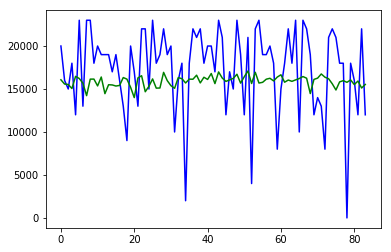

train mean: 17507.93650793651 2017 mean: 17380.95238095238 
2018 mean: 17369.04761904762 y_pred_mean: 15891.99353475487


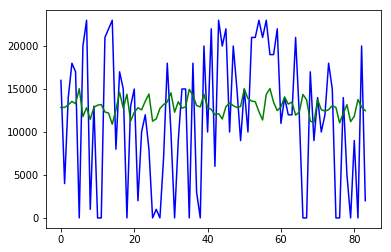

train mean: 13051.587301587302 2017 mean: 11833.333333333334 
2018 mean: 11738.095238095239 y_pred_mean: 12932.19841568002


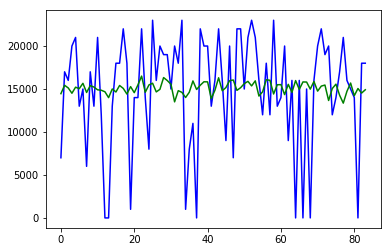

train mean: 15876.984126984127 2017 mean: 16000.0 
2018 mean: 14857.142857142857 y_pred_mean: 15106.89239440281


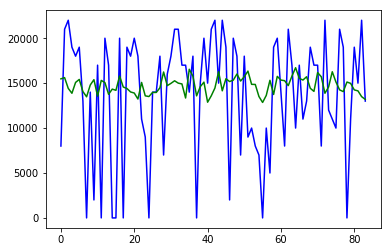

train mean: 14813.492063492064 2017 mean: 15261.904761904761 
2018 mean: 13678.57142857143 y_pred_mean: 14734.543727652974


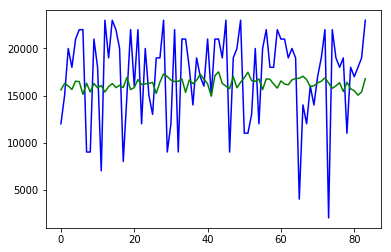

train mean: 17126.984126984127 2017 mean: 17333.333333333332 
2018 mean: 17202.380952380954 y_pred_mean: 16265.353110542575


[None, None, None, None, None]

In [56]:
def plot_block(blockid):
    train_blockid = train_blockid_dict[blockid]
    test_blockid  = test_blockid_dict[blockid]
    
    y1 = y_train_dow[train_blockid].flatten()  # blockid, month, dow = Jan (M,Tu,W,...,Sun), Feb (M,Tu,W,...,Sun), ... 
    y1_mean = np.mean(y1)

    train = pd.concat([pd.Series(X_train_dow[train_blockid].flatten()), pd.Series(y1)])
    train_mean = np.mean(train)

    y2 = y_test_dow[test_blockid].flatten()
    y2_mean = np.mean(y2)

    y_p = y_pred_dow[test_blockid].flatten()
    y_p_mean = np.mean(y_p)

    # plt.plot(np.arange(len(y1)), y1, color='red')  # 2017
    plt.plot(np.arange(len(y2)), y2, color='blue') # 2018
    plt.plot(np.arange(len(y_p)), y_p, color='green')
    plt.show()
    print('train mean:', train_mean, '2017 mean:', y1_mean, '\n2018 mean:', y2_mean, \
          'y_pred_mean:', y_p_mean)

[plot_block(i) for i in range(1, 6)]

## Day of week analysis for each month of each block id

(801, 24, 7) (801, 12, 7) (801, 24, 7) (801, 12, 7)
Number of data points: 67284
Number of non-zero elements: 56864
Percentage of non-zero elements: 0.8451340586172047


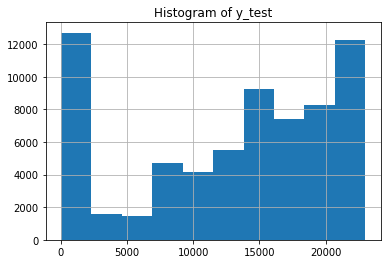

Correlation between y_train and y_test:
 [[1.         0.00763796]
 [0.00763796 1.        ]]
y_test shape after reshaping: (801, 84)
  Best training score: -0.5396818480070913
  Best testing score:  -0.12183101405010047
mean_squared_error: 51554326.56663896


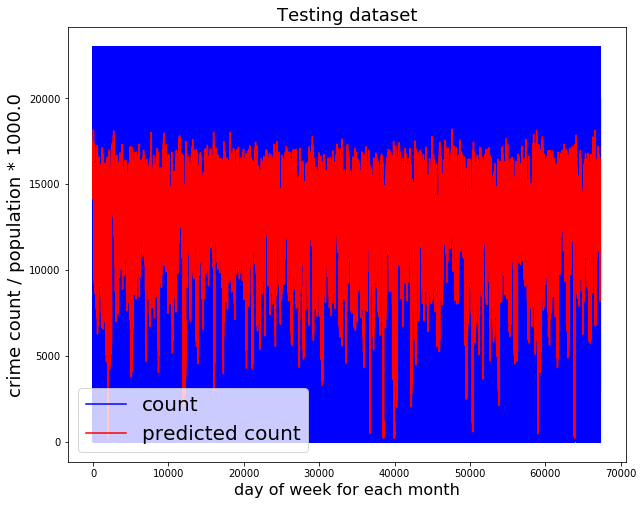

CPU times: user 2min 16s, sys: 1.81 s, total: 2min 18s
Wall time: 2min 51s


In [35]:
%%time

X_train_dow, X_test_dow, y_train_dow, y_test_dow = \
        ready_data(2015, 2017, train_blockid_dict,
                   X_test_start_year, X_test_end_year, test_blockid_dict,
                   DAY_OF_WEEK)

print(X_train_dow.shape, y_train_dow.shape, X_test_dow.shape, y_test_dow.shape)
model = MultiOutputRegressor(RandomForestRegressor(max_depth=5, n_estimators=100))
if use_counts == True:
    y_test_dow, y_pred_dow, rpd_dow, model_dow = \
        get_predictions(X_train_dow, y_train_dow, X_test_dow, y_test_dow, 
                        'day of week for each month', 
                        f'crime count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                        model, do_gridsearch=do_gridsearch)
else:
    y_test_dow, y_pred_dow, rpd_dow, model_dow = \
        get_predictions(X_train_dow, y_train_dow, X_test_dow, y_test_dow, 
                        'day of week for each month', 
                        f'risk {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                        model, do_gridsearch=do_gridsearch)

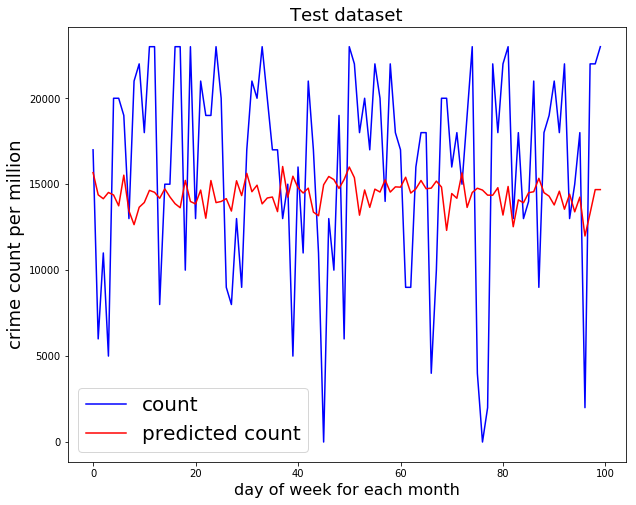

In [55]:
plot_output(y_test_dow.flatten()[:100], y_pred_dow.flatten()[:100], 'Test', 'day of week for each month', 'crime count per million')


## Day of month analysis for each month of each block id

In [56]:
# %%time

# X_train_dom, X_test_dom, y_train_dom, y_test_dom = \
#     ready_data(2015, 2017, train_blockid_dict,
#                X_test_start_year, X_test_end_year, test_blockid_dict,
#                DAY_OF_MONTH)

# print(X_train_dom.shape, y_train_dom.shape, X_test_dom.shape, y_test_dom.shape)

# model = MultiOutputRegressor(RandomForestRegressor(max_depth=4, n_estimators=120))
# if use_counts == True:
#     y_test_dom, y_pred_dom, rpd_dom, model_dom = \
#         get_predictions(X_train_dom, y_train_dom, X_test_dom, y_test_dom, 
#                         'day of month for each month', 
#                         f'crime count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
#                         model, do_gridsearch=do_gridsearch)
# else:
#     y_test_dom, y_pred_dom, rpd_dom, model_dom = \
#         get_predictions(X_train_dom, y_train_dom, X_test_dom, y_test_dom, 
#                         'day of month for each month', 
#                         f'risk {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
#                         model, do_gridsearch=do_gridsearch)

## Hour of day analysis for each month of each block id

(801, 24, 24) (801, 12, 24) (801, 24, 24) (801, 12, 24)
Number of data points: 230688
Number of non-zero elements: 120160
Percentage of non-zero elements: 0.5208766819253711


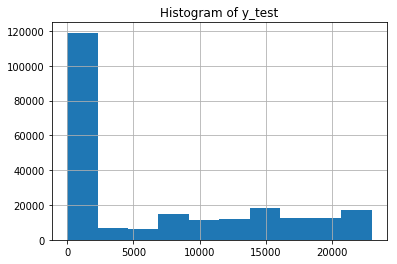

Correlation between y_train and y_test:
 [[1.         0.34832001]
 [0.34832001 1.        ]]
y_test shape after reshaping: (801, 288)
  Best training score: -0.4684929108353335
  Best testing score:  -0.2092251803585205
mean_squared_error: 34032102.002800375


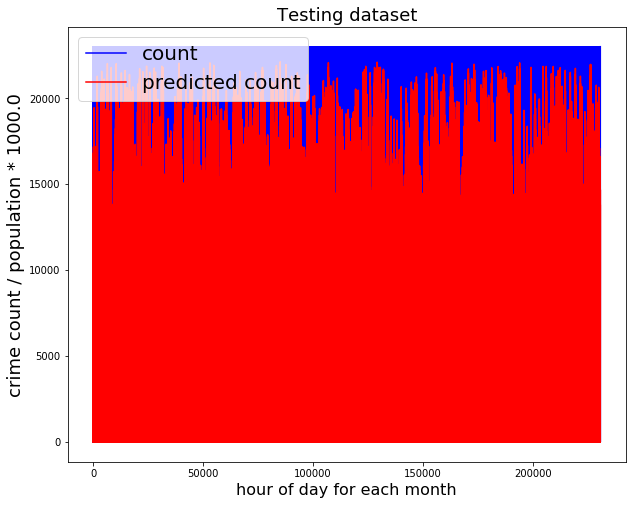

CPU times: user 5min 41s, sys: 1.22 s, total: 5min 42s
Wall time: 6min 24s


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:72: RuntimeWarning: invalid value encountered in true_divide


In [57]:
%%time

X_train_hod, X_test_hod, y_train_hod, y_test_hod = \
    ready_data(2015, 2017, train_blockid_dict,
               X_test_start_year, X_test_end_year, test_blockid_dict,
               HOUR_OF_DAY)

print(X_train_hod.shape, y_train_hod.shape, X_test_hod.shape, y_test_hod.shape)

model = MultiOutputRegressor(RandomForestRegressor(max_depth=4, n_estimators=120))
if use_counts == True:
    y_test_hod, y_pred_hod, rpd_hod, model_hod = \
        get_predictions(X_train_hod, y_train_hod, X_test_hod, y_test_hod, 
                        'hour of day for each month', 
                        f'crime count / population {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                        model, do_gridsearch=do_gridsearch)
else:
    y_test_hod, y_pred_hod, rpd_hod, model_hod = \
        get_predictions(X_train_hod, y_train_hod, X_test_hod, y_test_hod, 
                        'hour of day for each month', 
                        f'risk {SEVERITY_OPERATOR} {SEVERITY_SCALING_FACTOR}', 
                        model, do_gridsearch=do_gridsearch)

## Weigh and combine predictions into one array

In [66]:
NUM_BLOCKIDS       = 801
NUM_MONTHS_IN_YEAR = 12
NUM_DAYS_IN_WEEK   = 7
NUM_HOURS_IN_DAY   = 24

risks = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))
y_test_dow_times_hour = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))

# Returns number of days in a month
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

# Day of week returns 0-based day value
def day_of_week(dt):
    return dt.weekday()

end_year = X_test_end_year

for blockid in range(NUM_BLOCKIDS):
    for month in range(1, NUM_MONTHS_IN_YEAR + 1):
        for dow in range(7):
            for hour in range(24):

                weight_dow = 7
                weight_hod = 24

                weight_sum = weight_dow + weight_hod

                risks[blockid, month-1, dow * 24 + hour] += \
                    (y_pred_dow[blockid, (month - 1)*7+dow] * weight_dow +
                     y_pred_hod[blockid, (month - 1)*24+hour] * weight_hod) / weight_sum

                y_test_dow_times_hour[blockid, month-1, dow * 24 + hour] += \
                    (y_test_dow[blockid, (month - 1)*7+dow] * weight_dow +
                     y_test_hod[blockid, (month - 1)*24+hour] * weight_hod) / weight_sum                

risks_descaled = descale_data(risks)
risks_descaled = np.nan_to_num(risks_descaled)
risks = risks_descaled.copy()
y_test_dow_times_hour = descale_data(y_test_dow_times_hour)
y_test_dow_times_hour = np.nan_to_num(y_test_dow_times_hour)

In [67]:
y = y_test_dow_times_hour.flatten()
r = risks.flatten()
print('Number of zeros in y_test_dow_times_hour:', len(y[y == 0.0]), 'out of:', len(y))
print('Number of zeros in risks:', len(r[r == 0.0]), 'out of:', len(r))

Number of zeros in y_test_dow_times_hour: 175261 out of: 1614816
Number of zeros in risks: 0 out of: 1614816


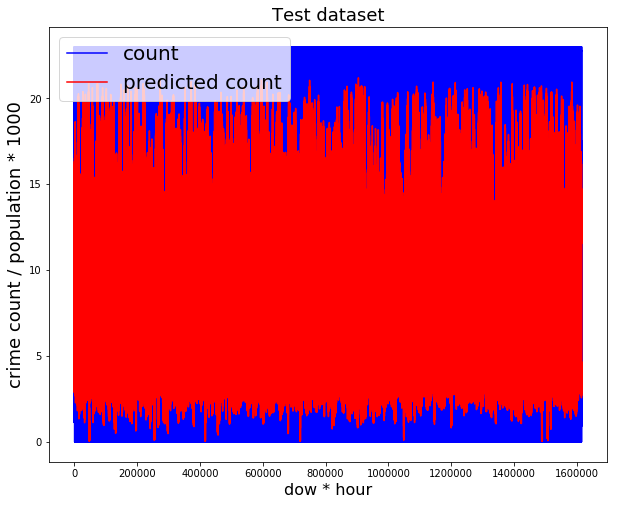

In [68]:
def plot_y_vs_ypred(y, y_pred):
    fig = plt.figure(figsize=(10, 8))

    plt.plot(np.arange(len(y.flatten())),
                 y.flatten(), color='blue');
    plt.plot(np.arange(len(y_pred.flatten())),
                 y_pred.flatten(), color='red');
    plt.xlabel('dow * hour', fontsize=16)
    plt.ylabel('crime count / population * 1000', fontsize=18)
    plt.title('Test dataset', fontsize=18)
    if use_counts == True:
        plt.legend(labels=['count', 'predicted count'], prop={'size': 20})
    else:
        plt.legend(labels=['risk', 'predicted risk'], prop={'size': 20})
    plt.show()
plot_y_vs_ypred(y_test_dow_times_hour, risks)

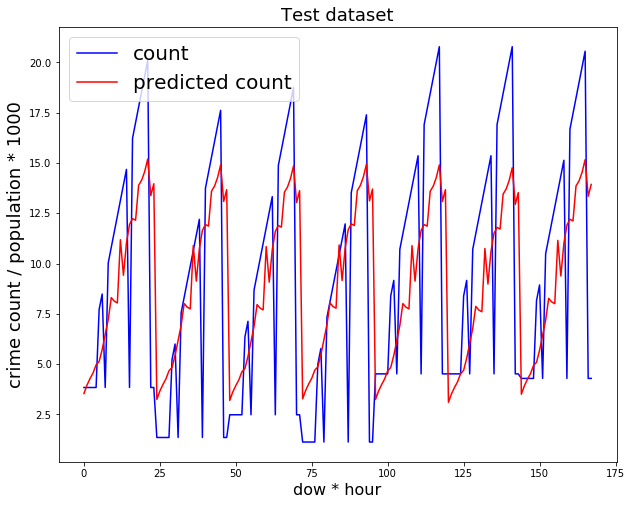

In [69]:
plot_y_vs_ypred(y_test_dow_times_hour[0][0], risks[0][0])

## Save data to file

In [71]:
import pickle

old_model_objs_to_pkl = [risks, test_blockid_dict]
with open("old_data.pkl", "wb") as f:
    pickle.dump(risks, f)
    pickle.dump(test_blockid_dict, f)

## Create predictions

In [72]:
X_test_start_year = 2017
X_test_end_year = 2019
X_train_dow, X_test_dow, y_train_dow, y_test_dow = \
        ready_data(2016, 2018, train_blockid_dict,
                   X_test_start_year, X_test_end_year, test_blockid_dict,
                   DAY_OF_WEEK)
X_train_dom, X_test_dom, y_train_dom, y_test_dom = \
        ready_data(2016, 2018, train_blockid_dict,
                   X_test_start_year, X_test_end_year, test_blockid_dict,
                   DAY_OF_MONTH)
X_train_hod, X_test_hod, y_train_hod, y_test_hod = \
        ready_data(2016, 2018, train_blockid_dict,
                   X_test_start_year, X_test_end_year, test_blockid_dict,
                   HOUR_OF_DAY)

In [73]:
y_pred_dow = model_dow.predict(X_test_dow.reshape((NUM_BLOCKIDS, X_test_dow.shape[1] * X_test_dow.shape[2])))
y_pred_hod = model_hod.predict(X_test_hod.reshape((NUM_BLOCKIDS, X_test_hod.shape[1] * X_test_hod.shape[2])))

In [74]:
y_test_dow = y_test_dow.reshape((TEST_NUM_BLOCKIDS, y_test_dow.shape[1] * y_test_dow.shape[2]))
y_test_hod = y_test_hod.reshape((TEST_NUM_BLOCKIDS, y_test_hod.shape[1] * y_test_hod.shape[2]))

In [75]:
NUM_BLOCKIDS       = 801
NUM_MONTHS_IN_YEAR = 12
NUM_DAYS_IN_WEEK   = 7
NUM_HOURS_IN_DAY   = 24

risks = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))
y_test_dow_times_hour = np.zeros((NUM_BLOCKIDS, NUM_MONTHS_IN_YEAR, NUM_DAYS_IN_WEEK * NUM_HOURS_IN_DAY))

# Returns number of days in a month
def days_in_month(year, month):
    p = pd.Period(f'{year}-{month}-1')
    return p.days_in_month

# Day of week returns 0-based day value
def day_of_week(dt):
    return dt.weekday()

end_year = X_test_end_year

for blockid in range(NUM_BLOCKIDS):
    for month in range(1, NUM_MONTHS_IN_YEAR + 1):
        for dow in range(7):
            for hour in range(24):

                weight_dow = 7
                weight_hod = 24

                weight_sum = weight_dow + weight_hod

                risks[blockid, month-1, dow * 24 + hour] += \
                    (y_pred_dow[blockid, (month - 1)*7+dow] * weight_dow +
                     y_pred_hod[blockid, (month - 1)*24+hour] * weight_hod) / weight_sum

                y_test_dow_times_hour[blockid, month-1, dow * 24 + hour] += \
                    (y_test_dow[blockid, (month - 1)*7+dow] * weight_dow +
                     y_test_hod[blockid, (month - 1)*24+hour] * weight_hod) / weight_sum                

risks_descaled = descale_data(risks)
risks_descaled = np.nan_to_num(risks_descaled)
risks = risks_descaled.copy()
y_test_dow_times_hour = descale_data(y_test_dow_times_hour)
y_test_dow_times_hour = np.nan_to_num(y_test_dow_times_hour)

## Store predictions in DB

In [76]:
from decouple import config

pred_blockid_dict = test_blockid_dict
def store_predictions_in_db(y_pred):
    
    DB_URI_WRITE  = config('DB_URI_WRITE')

    # Put predictions into pandas DataFrame with corresponding block id
    predictions = pd.DataFrame([[x] for x in pred_blockid_dict.keys()], columns=["id"])

    predictions.loc[:, "prediction"] = predictions["id"].apply(lambda x: y_pred[pred_blockid_dict[x],:,:].astype(np.float64).tobytes().hex())
    predictions.loc[:, "month"] = 0
    predictions.loc[:, "year"] = 2019
    predictions.to_csv("predictions.csv", index=False)

    # Query SQL
    query_commit_predictions = """
    CREATE TEMPORARY TABLE temp_predictions (
        id SERIAL PRIMARY KEY,
        prediction TEXT,
        month INTEGER,
        year INTEGER
    );

    COPY temp_predictions (id, prediction, month, year) FROM STDIN DELIMITER ',' CSV HEADER;

    UPDATE block
    SET 
        prediction = DECODE(temp_predictions.prediction, 'hex'),
        month = temp_predictions.month,
        year = temp_predictions.year 
    FROM temp_predictions
    WHERE block.id = temp_predictions.id;

    DROP TABLE temp_predictions;
    """

    # Open saved predictions and send to database using above query
    with open("predictions.csv", "r") as f:
        print("SENDING TO DB")
        RAW_CONN = create_engine(DB_URI_WRITE).raw_connection()
        cursor = RAW_CONN.cursor()
        cursor.copy_expert(query_commit_predictions, f)
        RAW_CONN.commit()
        RAW_CONN.close()

    for r in SESSION.execute("SELECT ENCODE(prediction::BYTEA, 'hex'), id FROM block WHERE prediction IS NOT NULL LIMIT 5;").fetchall():
        print(np.frombuffer(bytes.fromhex(r[0]), dtype=np.float64).reshape((12,7,24)))
        print(y_pred[pred_blockid_dict[int(r[1])], :].reshape((12,7,24)))

In [77]:
with session_scope() as SESSION:
    store_predictions_in_db(risks)

SENDING TO DB
[[[ 3.62226775  4.29141527  4.99341643 ... 18.65912714 19.76846219
   19.71990031]
  [ 3.48902621  4.15817373  4.86017489 ... 18.5258856  19.63522065
   19.58665876]
  [ 3.44368941  4.11283693  4.81483809 ... 18.48054881 19.58988385
   19.54132197]
  ...
  [ 3.72530414  4.39445167  5.09645283 ... 18.76216354 19.87149859
   19.8229367 ]
  [ 3.6650971   4.33424463  5.03624579 ... 18.7019565  19.81129155
   19.76272966]
  [ 3.55497764  4.22412516  4.92612633 ... 18.59183704 19.70117209
   19.6526102 ]]

 [[ 3.54364996  4.09162981  4.68260826 ... 17.90739264 18.94988511
   19.52136698]
  [ 3.24526502  3.79324488  4.38422333 ... 17.60900771 18.65150018
   19.22298204]
  [ 3.47677822  4.02475808  4.61573653 ... 17.84052091 18.88301337
   19.45449524]
  ...
  [ 3.26190582  3.80988568  4.40086413 ... 17.62564851 18.66814097
   19.23962284]
  [ 3.31992703  3.86790688  4.45888533 ... 17.68366971 18.72616218
   19.29764404]
  [ 3.61764469  4.16562455  4.756603   ... 17.98138738 19.0

## Load data from file

In [65]:
import pickle 

with open("old_data.pkl", "rb") as f:
    risks = pickle.load(f)
    test_blockid_dict = pickle.load(f)

In [ ]:
risks.shape, test_blockid_dict

In [ ]:
y_pred_dow[0].reshape((12, 7)).sum(axis=1)

In [ ]:
y_pred_dow[1].reshape((12, 7)).sum(axis=1)

In [ ]:
plt.plot(np.arange(len(y_pred_dow[0].flatten())),
             y_pred_dow[0].flatten(), color='blue');
plt.plot(np.arange(len(y_pred_dow[1].flatten())),
             y_pred_dow[1].flatten(), color='green');

In [ ]:
plt.plot(np.arange(len(y_pred_dow[0].flatten())),
             y_pred_dow[0].flatten(), color='blue');